# Variational Auto encoder 로 입력 이미지 출력하기

- mnist dataset 사용
- 데이터를 효율적으로 표현하는 방법을 학습하도록 제어함.
- 인코더와 디코더로 나누고 인코더 부분을 우리 데이터셋에 맞도록 변환하기 전 vae에 대해 이해해보고자 함.

Reference 
- [핸즈온 머신러닝]https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap15-Autoencoders/Chap15-Autoencoders.ipynb  
- https://keras.io/examples/generative/vae/
- https://wikidocs.net/152474
- https://taeu.github.io/paper/deeplearning-paper-vae/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 샘플링

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder 빌드하기

- 특징맵을 출력하는 conv layer가 2개, flatten 층이 1개, dense layer 1개로 구성된 nn이다.
- 활성화 함수로 relu를 사용, 스트라이드는 2, same 패딩 

In [3]:
#잠재벡터 차원 :2
latent_dim = 2

#인풋 이미지의 사이즈는 mnist 데이터셋을 이용하므로 28*28*1 이다.
#우리 이미지의 사이즈는 300*300*3 이고 이를 CNN 을 통해 
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Decoder 빌드하기

인코더를 통해 latent vector를 만들었고 이를 다시 원래의 인풋 이미지로 재생성해 출력해준다.

output shape을 보면 알 수 있듯 인풋 사이즈와 동일함을 확인할 수 있다.

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## VAE 정의

- encoder를 통해 인풋 이미지를 설명하는 feature를 latent vector에 담고, 이를 통해 새로운 데이터를 생성한다.
- 각 feature가 가우시안 분포를 따른다고 가정하고, latent vector은 각 feature의 평균과 분산값을 나타냄.

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## VAE 훈련하기

mnist dataset을 통해 훈련시킨다.

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 56s 98ms/step - loss: 259.7009 - reconstruction_loss: 212.5925 - kl_loss: 1.7888
Epoch 2/30
547/547 [==============================] - 54s 99ms/step - loss: 182.8106 - reconstruction_loss: 171.7501 - kl_loss: 5.0072
Epoch 3/30
547/547 [==============================] - 52s 95ms/step - loss: 168.9284 - reconstruction_loss: 162.3049 - kl_loss: 5.7074
Epoch 4/30
547/547 [==============================] - 53s 98ms/step - loss: 165.1021 - reconstruction_loss: 158.5448 - kl_loss: 5.9296
Epoch 5/30
547/547 [==============================] - 54s 99ms/step - loss: 162.9147 - reconstruction_loss: 156.1555 - kl_loss: 6.0965
Epoch 6/30
547/547 [==============================] - 55s 101ms/step - loss: 160.8294 - reconstruction_loss: 154.6271 - kl_loss: 6.1654
Epoch 7/30
547/547 [==============================] - 53s 97ms/step - loss: 159.6154 - reconstruction_loss: 153.4911 - kl_loss: 6.2086
Epoch 8/30
547/547 [==============================] - 

## 샘플링 이미지 확인하기

In [7]:
import matplotlib.pyplot as plt

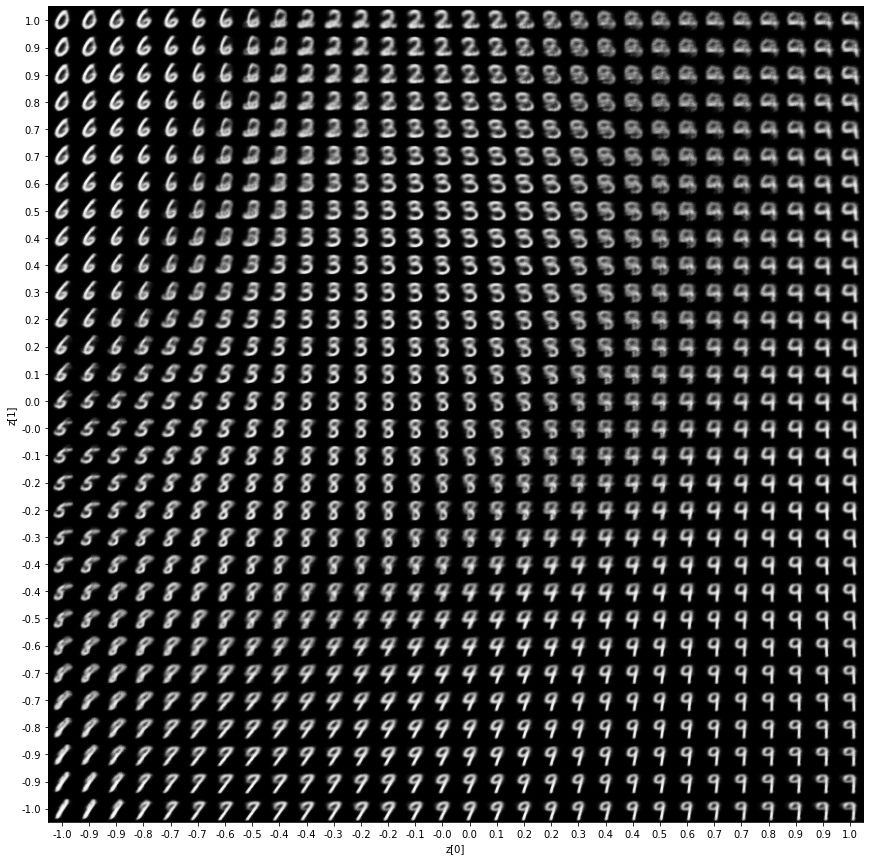

In [8]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Latent space Cluster 확인하기

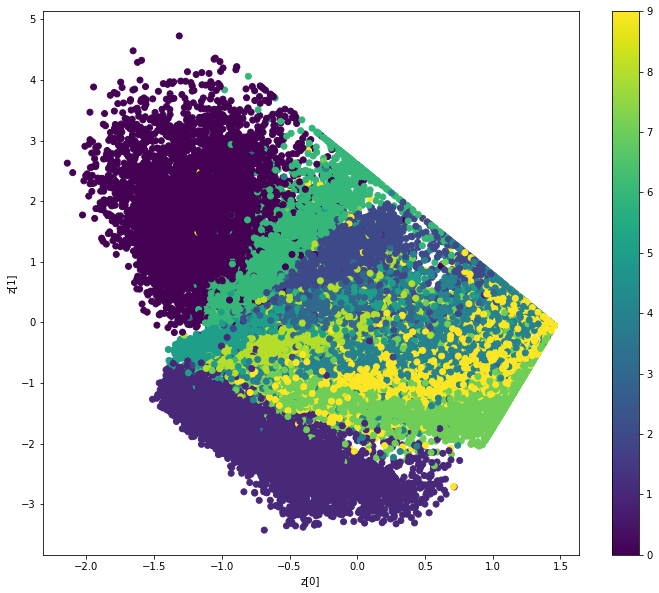

In [9]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [14]:
x_decoded

NameError: name 'x_decoded' is not defined

학습이 잘 될수록 2d 공간에 같은 숫자들을 생성하는 latent vector Z들은 뭉쳐져 있어야함.

알 수 있었던 것
1. 단순히 입력값을 단일값으로 재구성하는게 아니라 latent vector의 값을 가우시안 확률분포에 기반한 확률값으로 나타냄.
2. 이미지 유사도 계산에 사용하기 위해선 생성된 이미지를 다시 encoder를 거쳐 latent vector 형태로 (특징을 수치적으로 압축해 나타냄) 특징을 매핑해야함.

여기서 이 mnist 데이터 가지고 유사도를 구해보자.

해야할 것 
1. figure
z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit